#Mounting Drive

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


#Importing libraries

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout
from keras.models import Model
from keras.utils.vis_utils import plot_model
from scipy.sparse import vstack
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers


#Reading Data

In [3]:
ratings=pd.read_csv("/content/ratings.csv")
movies=pd.read_csv("/content/movies.csv")

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
  ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
ratings.drop("timestamp", axis=1, inplace=True)


In [7]:
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [8]:
ratings.shape

(100836, 3)

#making copy of data to edit in

In [9]:
df = ratings.copy()

In [10]:
df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


#mapping for users and movies

In [11]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

In [12]:
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

In [13]:
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)


In [14]:
df.head()

,userId,movieId,rating,user,movie
0,1,1,4.0,0,0
1,1,3,4.0,0,1
2,1,6,4.0,0,2
3,1,47,5.0,0,3
4,1,50,5.0,0,4


#Get info about rating column to be used later

In [15]:
num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


#Normalize the rating column

In [16]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values


#Splitting data

In [17]:
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)


#**Model**

In [18]:
EMBEDDING_SIZE = 50
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
)


#Model training

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=256,
    epochs=200,
    verbose=1,
    validation_data=(x_val, y_val),
)


Epoch 1/200
316/316 [==============================] - 12s 34ms/step - loss: 0.6923 - val_loss: 0.6892
Epoch 2/200
316/316 [==============================] - 3s 8ms/step - loss: 0.6509 - val_loss: 0.6827
Epoch 3/200
316/316 [==============================] - 3s 11ms/step - loss: 0.6365 - val_loss: 0.6776
Epoch 4/200
316/316 [==============================] - 3s 11ms/step - loss: 0.6333 - val_loss: 0.6756
Epoch 5/200
316/316 [==============================] - 3s 10ms/step - loss: 0.6320 - val_loss: 0.6747
Epoch 6/200
316/316 [==============================] - 3s 8ms/step - loss: 0.6305 - val_loss: 0.6735
Epoch 7/200
316/316 [==============================] - 4s 13ms/step - loss: 0.6292 - val_loss: 0.6727
Epoch 8/200
316/316 [==============================] - 3s 9ms/step - loss: 0.6283 - val_loss: 0.6714
Epoch 9/200
316/316 [==============================] - 2s 6ms/step - loss: 0.6270 - val_loss: 0.6704
Epoch 10/200
316/316 [==============================] - 2s 6ms/step - loss: 0.6262 - 

#Model Summary

In [ ]:
model.summary()


Model: "recommender_net_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    multiple                  30500     
                                                                 
 embedding_37 (Embedding)    multiple                  610       
                                                                 
 embedding_38 (Embedding)    multiple                  486200    
                                                                 
 embedding_39 (Embedding)    multiple                  9724      
                                                                 
Total params: 527,034
Trainable params: 527,034
Non-trainable params: 0
_________________________________________________________________


#plotting the training and test loss

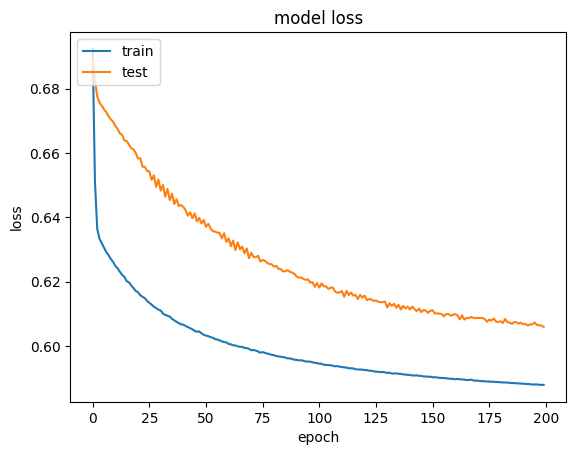

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


#Evaluating the Model

In [ ]:
y_pred = model.predict(x_val)
y_true =  y_val

rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print('\n\nTesting Result : {:.4f} RMSE'.format(rmse))

631/631 [==============================] - 2s 3ms/step


Testing Result : 0.2306 RMSE


#Testing the Model

In [26]:
def get_recommendations(model, user_id, k):
    movies_watched_by_user = df[df.userId == user_id]
    movies_not_watched = movies[
        ~movies["movieId"].isin(movies_watched_by_user.movieId.values)
    ]["movieId"]
    movies_not_watched = list(
        set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
    )
    movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
    user_encoder = user2user_encoded.get(user_id)
    user_movie_array = np.hstack(
        ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
    )
    ratings = model.predict(user_movie_array).flatten()
    top_ratings_indices = ratings.argsort()[-k:][::-1]
    recommended_movie_ids = [
        movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
    ]

    recommended_movies = movies[movies["movieId"].isin(recommended_movie_ids)]
    recommended_movies = recommended_movies.merge(
        pd.DataFrame({"movieId": recommended_movie_ids, "rating": ratings[top_ratings_indices]}),
        on="movieId",
    )
    recommended_movies = recommended_movies.sort_values("rating", ascending=False).reset_index(drop=True)

    return recommended_movies[["title", "genres"]].head(k)


In [28]:
get_recommendations(model,500, 10)

302/302 [==============================] - 1s 2ms/step


,title,genres
0,"Shawshank Redemption, The (1994)",Crime|Drama
1,Fight Club (1999),Action|Crime|Drama|Thriller
2,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
3,Lawrence of Arabia (1962),Adventure|Drama|War
4,Rear Window (1954),Mystery|Thriller
5,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
6,"Godfather, The (1972)",Crime|Drama
7,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
8,Apocalypse Now (1979),Action|Drama|War
9,"Streetcar Named Desire, A (1951)",Drama



#Model saving

In [ ]:
model.save('/content/drive/MyDrive/Recommender Systems/project', save_format='tf')


#Model loading

In [19]:
nfc_model=keras.models.load_model('/content/drive/MyDrive/Recommender Systems/project')

In [25]:
get_recommendations(nfc_model,213, 20)

302/302 [==============================] - 1s 4ms/step


,title,genres
0,"Shawshank Redemption, The (1994)",Crime|Drama
1,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
2,Rear Window (1954),Mystery|Thriller
3,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
4,Fight Club (1999),Action|Crime|Drama|Thriller
5,Lawrence of Arabia (1962),Adventure|Drama|War
6,Apocalypse Now (1979),Action|Drama|War
7,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
8,"Departed, The (2006)",Crime|Drama|Thriller
9,"Streetcar Named Desire, A (1951)",Drama


#**Additional work**
we tried to search about pretrained model to see how it works and the following is pretrained model in the same large version dataset from hugging face

install hugging face

In [ ]:
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Get the model

In [ ]:
from huggingface_hub import from_pretrained_keras

nfc_hugg_model = from_pretrained_keras("keras-io/collaborative-filtering-movielens")


config.json not found in HuggingFace Hub.


Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
get_recommendations(nfc_hugg_model,213, 10)

302/302 [==============================] - 1s 4ms/step
Showing recommendations for user: 213
Top 10 movie recommendations
------------------------------
Braveheart (1995) : Action|Drama|War
Hideaway (1995) : Thriller
Three Caballeros, The (1945) : Animation|Children|Musical
Last of the Mohicans, The (1992) : Action|Romance|War|Western
Seven Samurai (Shichinin no samurai) (1954) : Action|Adventure|Drama
Beetlejuice (1988) : Comedy|Fantasy
Commitments, The (1991) : Comedy|Drama|Musical
Longest Day, The (1962) : Action|Drama|War
Adaptation (2002) : Comedy|Drama|Romance
Burn After Reading (2008) : Comedy|Crime|Drama


#**Thank You**